In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np

# PyMC for Bayesian statistical modeling and probabilistic machine learning
import pymc as pm
# ArviZ for exploratory analysis of Bayesian models
import arviz as az

# Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data into DataFrames
df4 = pd.read_csv('../Data/clean/Cohort4Clean.csv')
df5 = pd.read_csv('../Data/clean/Cohort5Clean.csv')
pics = pd.read_csv('../pics/pics.csv')

# Concatenate df4 and df5 to create a combined DataFrame
df = pd.concat([df4,df5])

# Drop duplicate rows based on the 'ID' column
df = df.drop_duplicates(subset=['ID'])

# Add Z score for EN score
df['EmotionalNumbingZ'] = (df['EmotionalNumbing'] - df['EmotionalNumbing'].mean()) / df['EmotionalNumbing'].std()
df['AgeZ'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()

# Print the shape (number of rows and columns) of the combined and deduplicated DataFrame
print(df.shape)


(1380, 64)


original file: (42780, 11) clean file: (42360, 11)


<AxesSubplot:xlabel='scale_rating', ylabel='rating'>

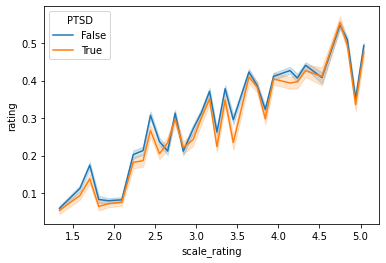

In [3]:
# Transform the DataFrame 'df' from wide to long format using 'melt'
# 'ID', 'PTSD', 'A', 'EmotionalNumbing', and 'PHQ' columns are kept as identifiers
# The values from columns 3 to 43 are reshaped into two columns: 'pic' (variable) and 'rating' (value)
df_long = pd.melt(df, id_vars=['ID','PTSD','Age','EmotionalNumbing','MDD','EmotionalNumbingZ', 'AgeZ'], 
                  value_vars=list(df.columns[3:43]),
                  var_name='pic', 
                  value_name='rating')

# Merge 'df_long' with the 'pics' DataFrame on the 'pic' column
# This operation adds information from 'pics' to 'df_long' based on picture names
# The merged DataFrame is then sorted by 'PTSD' and 'ID'
df_long = df_long.merge(pics, left_on='pic', right_on='pic').sort_values(['PTSD','ID'])

# Scale the 'rating' column by dividing each value by 100
df_long['rating'] = df_long['rating']/100

# Create a new column 'scale_rating' by copying values from 'NAPSr' column
df_long['scale_rating'] = df_long['NAPSr']

# Filter the DataFrame to keep only Neutral to negative pictures
df_long = df_long[df_long['scale_rating']<5.5].reset_index(drop=True)

# Remove rows from 'df_long' where 'rating' has missing (NaN) values
# Store the resulting DataFrame in 'df_long_c'
df_long_c = df_long.dropna(subset='rating').reset_index(drop=True)

# Print the shapes (number of rows and columns) of the original and cleaned DataFrames
# This provides a quick comparison of how many rows were dropped due to missing values in the 'rating' column
print("original file:", df_long.shape, "clean file:", df_long_c.shape)

# Plot the data using Seaborn's lineplot
# The x-axis represents 'scale_rating', the y-axis represents 'participants rating', and data points are colored based on the 'pPTSD' diagnosis
sns.lineplot(data=df_long, x='scale_rating', y='rating', hue='PTSD')

## Define models 

In [4]:
def pl5_hyper(df_all, idx, n_sub, a1_v = 2, a2_v = 10, b_v = 2, c_v = 2, d_v = 2, g_v = 4):
    """
    Bayesian hierarchical model using 5-Parameter Logistic (5PL) regression.
    
    Parameters:
    - df_all: DataFrame containing data.
    - idx: Index for hierarchical grouping.
    - n_sub: Number of subjects/groups.
    
    Returns:
    - trace: Samples from the posterior distribution.
    """
    
  
    # Define a probabilistic model using PyMC
    with pm.Model() as five_PL:
        
        a1   = pm.TruncatedNormal('a1',   a1_v, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',            a2_v, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', b_v, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', c_v, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', d_v, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', g_v, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
        

        # Define prior for standard deviation of observations
        eps = pm.Exponential('eps', 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**b[idx])**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        # Sample from the posterior distribution
        trace = pm.sample()

    return trace

In [5]:
def plot_hist(Control, PTSD, ax1_name, ax2_name, hpd=5.5, binw = .001, group1 = 'TEC', group2 = 'pPTSD'):
    
    """
    Function to plot histograms comparing two groups (Control and PTSD).
    
    Parameters:
    - Control: Data for the control group
    - PTSD: Data for the PTSD group
    - ax1_name: Title for the first subplot
    - ax2_name: Title for the second subplot
    - hpd: Threshold for Highest Posterior Density interval (default is 5.5)
    - binw: Bin width for the histograms (default is 0.001)
    """
    
    # Compute the difference between the mean values of the control and PTSD groups
    difference = Control-PTSD
    
    # Calculate the percentiles for the differences, using the HPD
    q1, q2 = np.percentile(difference, [hpd, 100-hpd])
    
    # Filter out the data based on the lower (q1) and higher (q2) thresholds
    bottom_data = difference[difference <= q1]
    top_data = difference[difference >= q2]


    # Create a new figure with two subplots
    f, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the distributions of the provided datasets (e.g., lower asymptote values) for both groups in the first subplot
    sns.histplot(Control, binwidth=binw, ax=ax[0])
    sns.histplot(PTSD,    binwidth=binw, ax=ax[0])

    # Plot the distribution of the differences in the second subplot
    sns.histplot(data=difference, color='blue', ax=ax[1])

    # Update the bar colors in the difference histogram based on their position relative to the thresholds
    for bar in ax[1].patches:
        if bar.get_x() > q2:
            bar.set_color('orange')
        elif bar.get_x() < q1:
            bar.set_color('orange')
        else:
            bar.set_color('blue')

    # Add a reference line at zero in the difference histogram
    ax[1].axvline(0, color='black', linewidth=4)
    

    # Set titles for the subplots based on the provided names
    ax[0].set_title(ax1_name)
    ax[1].set_title(ax2_name)
    
    # Get the x and y limits of the first subplot
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()

    # Convert the desired 0.25 inches offset into a proportional x-axis distance
    fig_width_in_inches = f.get_figwidth()  # figure width in inches
    proportional_distance = 0.25 / fig_width_in_inches * (xlim[1] - xlim[0])

    # Set the text relative to the upper right corner
    text_offset_x = xlim[1] - proportional_distance
    text_offset_y_1 = ylim[1] - (ylim[1] * 0.1)  # 10% from the top for the first text
    text_offset_y_2 = ylim[1] - (ylim[1] * 0.2)  # 20% from the top for the second text

    text = group1
    ax[0].text(text_offset_x, text_offset_y_1, text, fontsize=18, color='#1f77b4', ha='right')
    text = group2
    ax[0].text(text_offset_x, text_offset_y_2, text, fontsize=18, color='orange', ha='right')
    
    print("mean: ", np.mean(difference), "89% HDPi: ",q1,q2)

## Check different parameters

In [6]:
# Count the number of unique IDs (subjects) in the original 'df' DataFrame for which 'PTSD' is False/True (control/PTSD group)
n_control = len(df[df['PTSD']==False]['ID'].unique())
n_PTSD = len(df[df['PTSD']==True]['ID'].unique())

# Filter out rows from the cleaned DataFrame 'df_long_c' where 'PTSD' is False/Fales (control/PTSD group)
# and reset the index of the resulting DataFrame
df_c = df_long_c[df_long_c['PTSD']==False].reset_index(drop=True)
df_p = df_long_c[df_long_c['PTSD']==True].reset_index(drop=True)

# Add a new column 'sub_id' to the 'df_c'/'df_p' DataFrame that assigns a unique rank (ID) to each unique subject
# The 'rank' method with 'dense' ensures that every unique ID gets a unique rank without skipping numbers
df_c['sub_id'] = df_c['ID'].rank(method='dense')-1
df_p['sub_id'] = df_p['ID'].rank(method='dense')-1

# Extract the 'sub_id' column values from 'df_c' and 'df_p' and store them as integer lists
# These lists can later be used as indices for group-level hierarchical models or similar purposes
idx_c = df_c['sub_id'].values
idx_c = [int(i) for i in idx_c]

idx_p = df_p['sub_id'].values
idx_p = [int(i) for i in idx_p]

In [7]:
a_values = [(4, 20), (2, 5), (5, 5)]  
b_values = [1, 1.5, 2] 
c_values = [1, 2, 3] 
d_values = [1.5, 2, 2.5]  
g_values = [3, 4, 5]  

traces_c_a = []
traces_p_a = []
traces_c_b = []
traces_p_b = []
traces_c_c = []
traces_p_c = []
traces_c_d = []
traces_p_d = []
traces_c_g = []
traces_p_g = []

In [8]:
for a in a_values:
    trace_c = pl5_hyper(df_c, idx_c, n_control, a1_v=a[0], a2_v=a[1])  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_c_a.append(trace_c)
    trace_p = pl5_hyper(df_p, idx_p, n_PTSD, a1_v=a[0], a2_v=a[1])  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_p_a.append(trace_p)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1738 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 599 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1786 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 518 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1547 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 513 seconds.


In [9]:
for b in b_values:
    trace_c = pl5_hyper(df_c, idx_c, n_control, b_v=b)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_c_b.append(trace_c)
    trace_p = pl5_hyper(df_p, idx_p, n_PTSD, b_v=b)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_p_b.append(trace_p)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1269 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 425 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1184 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 419 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1260 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 422 seconds.


In [10]:
for c in c_values:
    trace_c = pl5_hyper(df_c, idx_c, n_control, c_v=c)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_c_c.append(trace_c)
    trace_p = pl5_hyper(df_p, idx_p, n_PTSD, c_v=c)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_p_c.append(trace_p)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1267 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 416 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1262 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 417 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1043 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 410 seconds.


In [11]:
for d in d_values:
    trace_c = pl5_hyper(df_c, idx_c, n_control, d_v=d)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_c_d.append(trace_c)
    trace_p = pl5_hyper(df_p, idx_p, n_PTSD, d_v=d)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_p_d.append(trace_p)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1259 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 430 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1269 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 415 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1259 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 420 seconds.


In [12]:
for g in g_values:
    trace_c = pl5_hyper(df_c, idx_c, n_control, g_v=g)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_c_g.append(trace_c)
    trace_p = pl5_hyper(df_p, idx_p, n_PTSD, g_v=g)  # Assuming pl5_hyper is modified to accept mu_b as a parameter
    traces_p_g.append(trace_p)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1262 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 414 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1248 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 418 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1096 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 412 seconds.


mean:  -0.2296057717164711 89% HDPi:  -0.3105054376334484 -0.1525370850721992
mean:  -0.2833386051107916 89% HDPi:  -0.3735820495745601 -0.19251438543549387
mean:  -0.28439357374878005 89% HDPi:  -0.37571724703246356 -0.1932016766732
mean:  -0.2618389540645419 89% HDPi:  -0.3493747078176952 -0.17316009488273945
mean:  -0.2643895524528174 89% HDPi:  -0.35579784499952805 -0.17746656356931823
mean:  -0.26508392572785433 89% HDPi:  -0.35750798140385304 -0.17594801528199439
mean:  -0.264241677484704 89% HDPi:  -0.3545708036973725 -0.17475760129150783
mean:  -0.26337840896720416 89% HDPi:  -0.3513886643436314 -0.17396610347027808
mean:  -0.2638341773059923 89% HDPi:  -0.3503106729828585 -0.1776036479820245
mean:  -0.26418733051730614 89% HDPi:  -0.35413265720613196 -0.17428983080242733
mean:  -0.26473103933929565 89% HDPi:  -0.3535265258952244 -0.17873285806717118
mean:  -0.26653207285798736 89% HDPi:  -0.35739440892534696 -0.17399688212662928
mean:  -0.263887236147186 89% HDPi:  -0.35240447

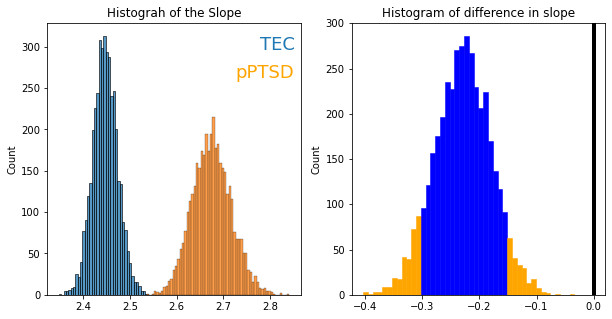

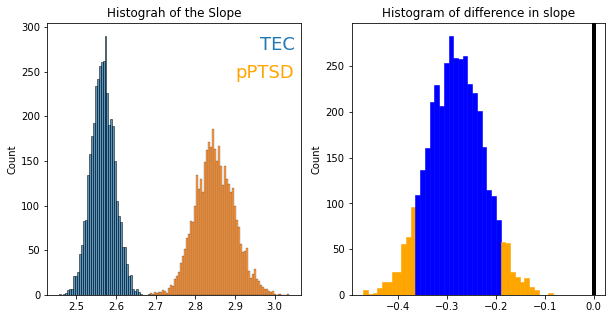

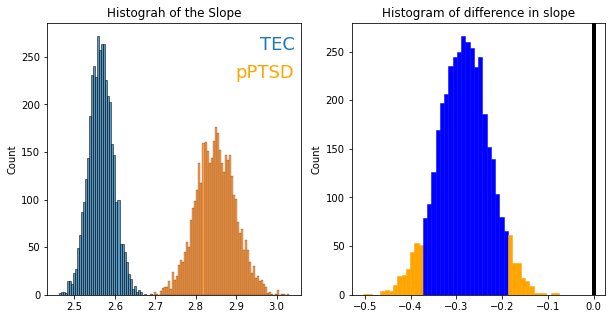

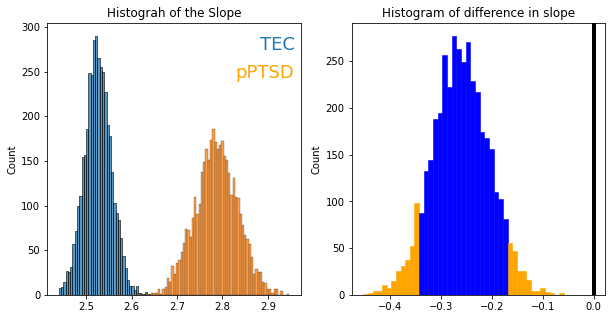

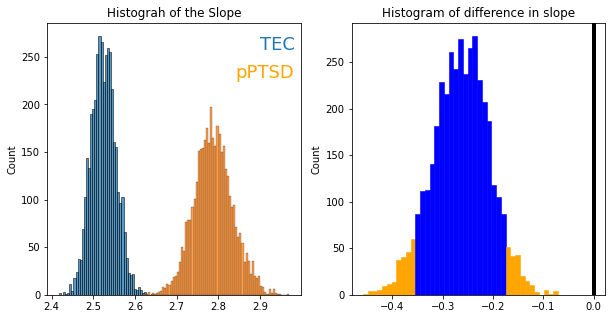

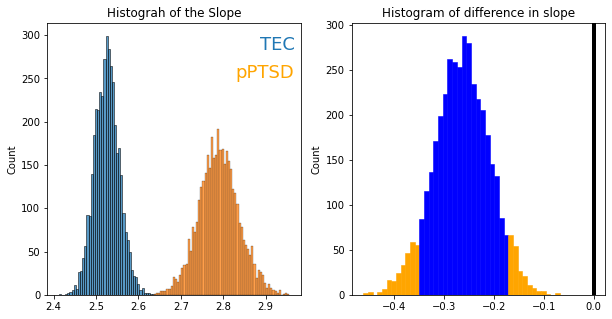

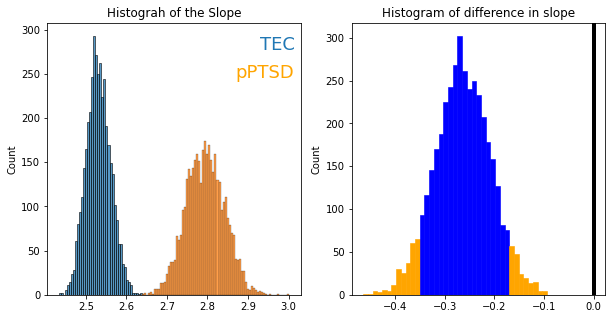

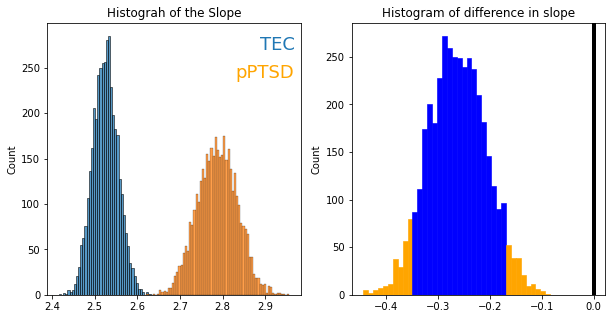

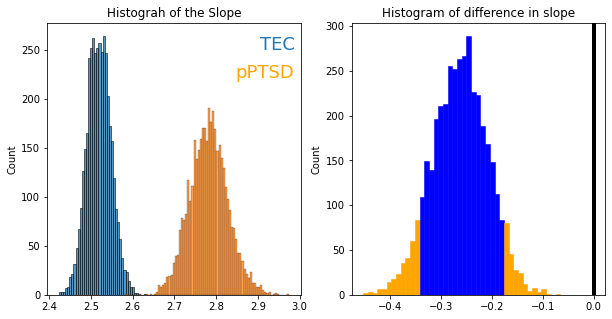

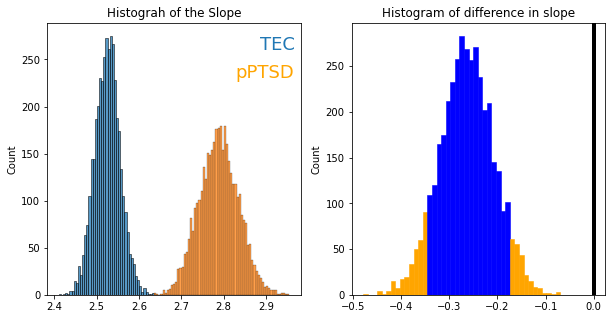

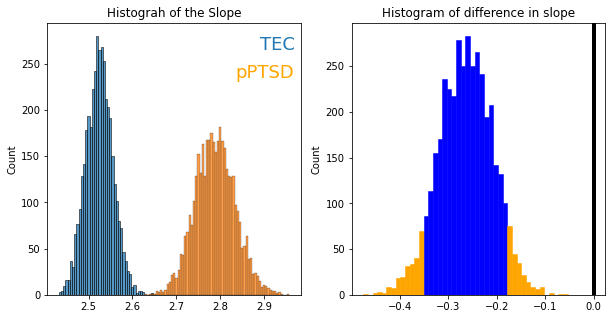

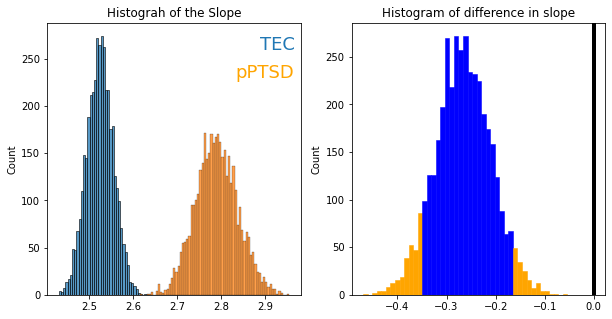

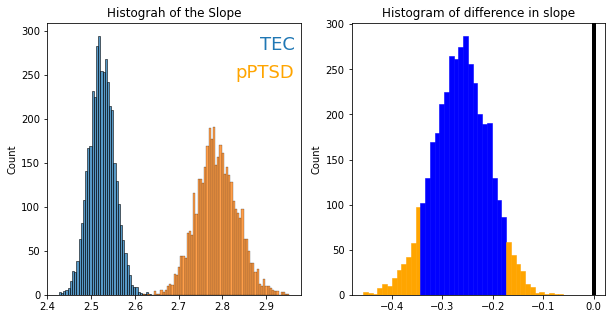

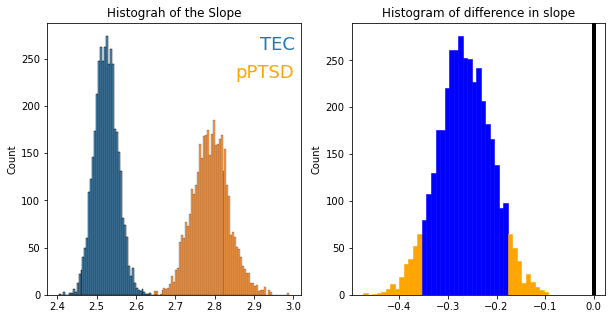

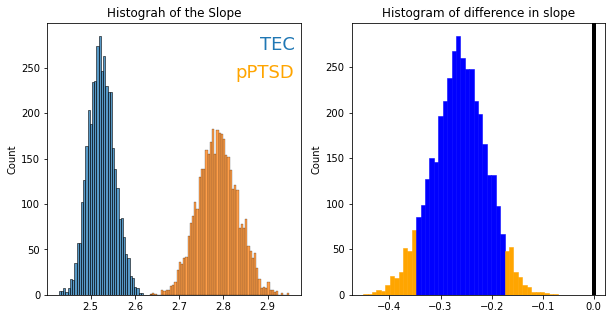

In [13]:
for param in [(traces_c_a, traces_p_a), 
              (traces_c_b, traces_p_b), 
              (traces_c_c, traces_p_c), 
              (traces_c_d, traces_p_d), 
              (traces_c_g, traces_p_g)]:
    for i in range (3):
        tr_c = param[0][i].posterior.stack(draws=("chain", "draw"))
        tr_p = param[1][i].posterior.stack(draws=("chain", "draw"))
        
        # Calculate the mean value of the slope parameter
        Control = np.mean(tr_c.b[:,:].values, axis = 0)
        PTSD    = np.mean(tr_p.b[:,:].values, axis = 0)

        plot_hist(Control, PTSD, 'Histograh of the Slope', 'Histogram of difference in slope', binw=.005)

# Check different sample Sizes

In [14]:
df_p = df[df.PTSD==True]
df_c = df[df.PTSD==False]
print(df_c.shape, df_p.shape)

(925, 64) (455, 64)


In [15]:
sub_c = []
sub_p = []

for i in range(10):
    n = 40 * (i+1)
    df_p_s = df_p.sample(n=n)
    df_c_s = df_c.sample(n=n)

    df_s = pd.concat([df_p_s,df_c_s])

    df_long_s = pd.melt(df_s, id_vars=['ID','PTSD','Age','EmotionalNumbing','EmotionalNumbingZ'], 
                      value_vars=list(df.columns[3:43]),
                      var_name='pic', 
                      value_name='rating')


    df_long_s = df_long_s.merge(pics, left_on='pic', right_on='pic').sort_values(['PTSD','ID'])

    df_long_s['rating'] = df_long_s['rating']/100

    df_long_s['scale_rating'] = df_long_s['NAPSr']

    df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)

    df_long_s_c = df_long_s.dropna(subset='rating').reset_index(drop=True)

    print("n:", n, "original file:", df_long_s.shape, "clean file:", df_long_s_c.shape)
    
    # Count the number of unique IDs (subjects) in the original 'df' DataFrame for which 'PTSD' is False/True (control/PTSD group)
    n_control = len(df_s[df_s['PTSD']==False]['ID'].unique())
    n_PTSD = len(df_s[df_s['PTSD']==True]['ID'].unique())

    # Filter out rows from the cleaned DataFrame 'df_long_c' where 'PTSD' is False/Fales (control/PTSD group)
    # and reset the index of the resulting DataFrame
    df_c1 = df_long_s_c[df_long_s_c['PTSD']==False].reset_index(drop=True)
    df_p1 = df_long_s_c[df_long_s_c['PTSD']==True].reset_index(drop=True)

    # Add a new column 'sub_id' to the 'df_c'/'df_p' DataFrame that assigns a unique rank (ID) to each unique subject
    # The 'rank' method with 'dense' ensures that every unique ID gets a unique rank without skipping numbers
    df_c1['sub_id'] = df_c1['ID'].rank(method='dense')-1
    df_p1['sub_id'] = df_p1['ID'].rank(method='dense')-1

    # Extract the 'sub_id' column values from 'df_c' and 'df_p' and store them as integer lists
    # These lists can later be used as indices for group-level hierarchical models or similar purposes
    idx_c1 = df_c1['sub_id'].values
    idx_c1 = [int(i) for i in idx_c1]

    idx_p1 = df_p1['sub_id'].values
    idx_p1 = [int(i) for i in idx_p1]
    
    trace_c = pl5_hyper(df_c1, idx_c1, n_control)
    sub_c.append(trace_c)
    trace_p = pl5_hyper(df_p1, idx_p1, n_PTSD)
    sub_p.append(trace_p)

n: 40 original file: (2800, 9) clean file: (2800, 9)


/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 80 original file: (5600, 9) clean file: (5600, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 120 original file: (8400, 9) clean file: (8298, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 160 original file: (11200, 9) clean file: (11114, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 194 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 200 original file: (14000, 9) clean file: (13880, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 229 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 222 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 240 original file: (16800, 9) clean file: (16638, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 262 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 260 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 280 original file: (19600, 9) clean file: (19423, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 299 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 295 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 320 original file: (22400, 9) clean file: (22205, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 343 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 328 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 360 original file: (25200, 9) clean file: (24903, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 377 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 362 seconds.
/tmp/ipykernel_38622/3009324833.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_s = df_long_s[df_long['scale_rating']<5.5].reset_index(drop=True)


n: 400 original file: (28000, 9) clean file: (27707, 9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 419 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 400 seconds.


mean:  0.01479865596221176 89% HDPi:  -0.35948532790995624 0.37416321881514225
mean:  -0.18473976356770583 89% HDPi:  -0.457157650280729 0.07574404549754196
mean:  -0.19693273058968594 89% HDPi:  -0.40113359448337327 0.01114649013459778
mean:  -0.17760287513300546 89% HDPi:  -0.3499184097483378 -0.0020389882327836446
mean:  -0.29926312731593135 89% HDPi:  -0.45468351118106104 -0.14651970609812512
mean:  -0.1560825760215211 89% HDPi:  -0.290577183325215 -0.02330030327460654
mean:  -0.2617871319358714 89% HDPi:  -0.38568227643520375 -0.1391358938679382
mean:  -0.23183550569162548 89% HDPi:  -0.3514456399401397 -0.11196284574998536
mean:  -0.24692694442816565 89% HDPi:  -0.35729344441581695 -0.13492854385091813
mean:  -0.3164964663150141 89% HDPi:  -0.41742212393646416 -0.21492026300046754


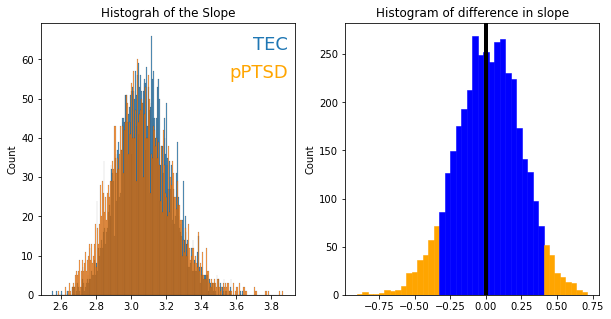

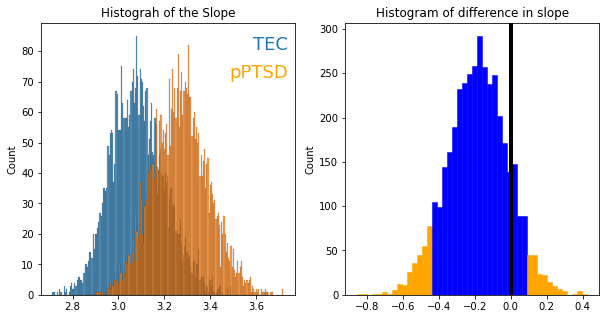

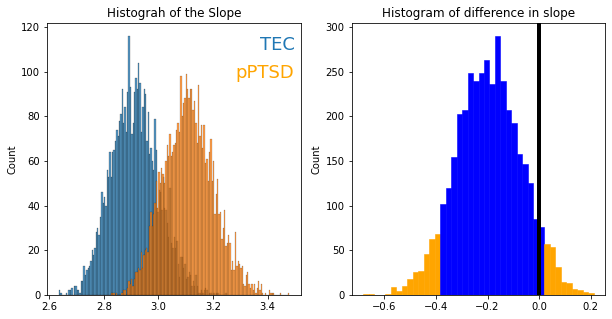

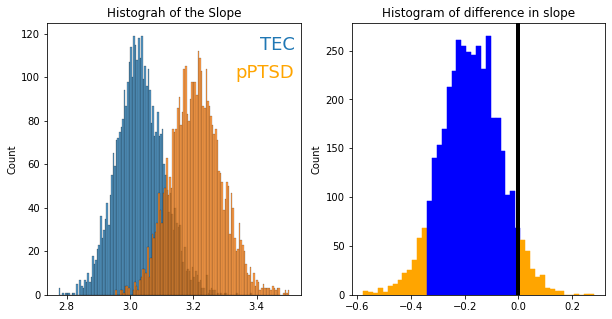

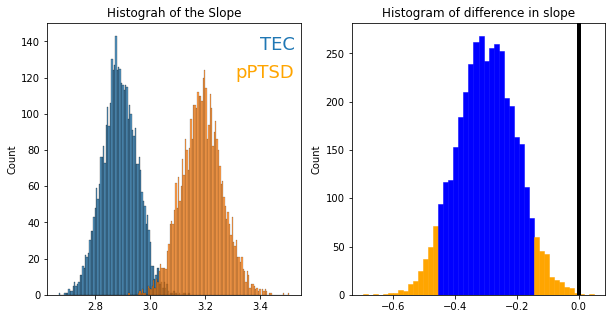

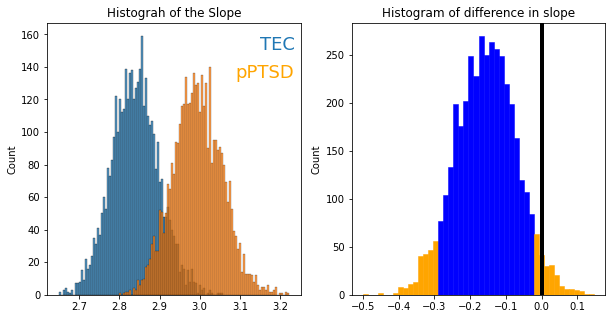

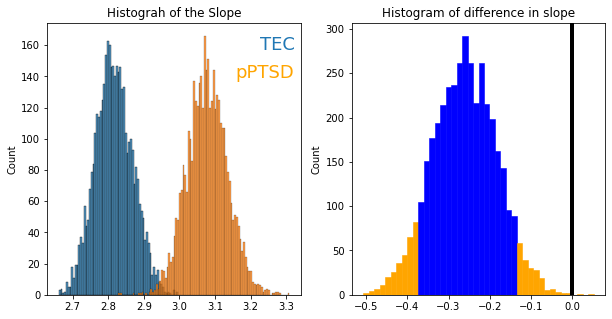

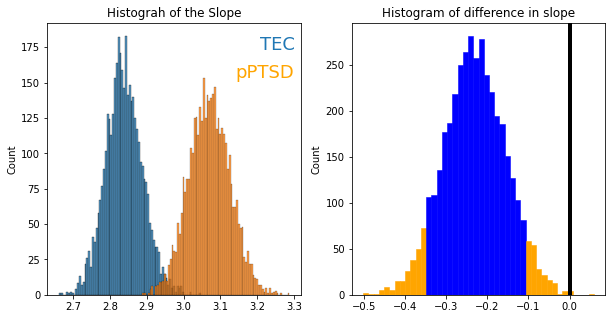

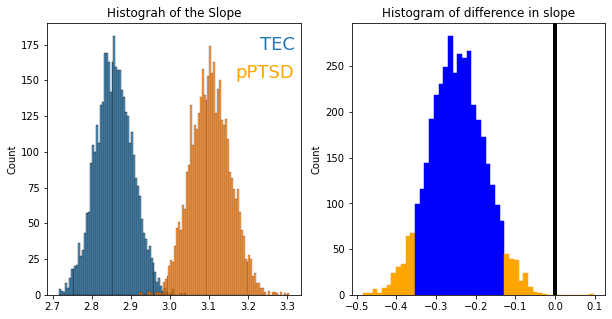

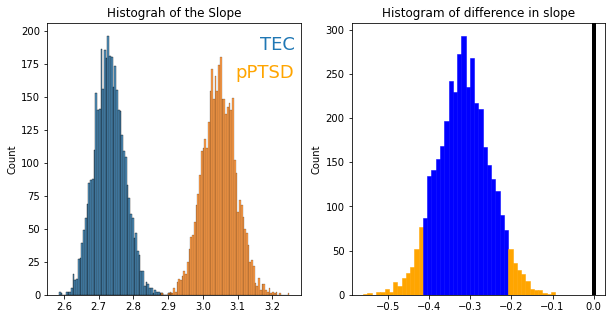

In [16]:
for i in range (10):
    tr_c = sub_c[i].posterior.stack(draws=("chain", "draw"))
    tr_p = sub_p[i].posterior.stack(draws=("chain", "draw"))

    # Calculate the mean value of the slope parameter
    Control = np.mean(tr_c.b[:,:].values, axis = 0)
    PTSD    = np.mean(tr_p.b[:,:].values, axis = 0)

    plot_hist(Control, PTSD, 'Histograh of the Slope', 'Histogram of difference in slope', binw=.005)

# Check Emotional Numbing w/o Z transformation

In [17]:
def pl5_hyper_emotion(df_all, idx, n_sub):
    

    with pm.Model() as five_PL:
        
        # hyper priors
        # Define hyperpriors for group-level parameters
        a1   = pm.TruncatedNormal('a1',   2, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',           10, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', 2, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', 2, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', 2, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', 4, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
                
        EN_slope = pm.Normal('EN_slope', 0, 1)
        
        s = b[idx] + EN_slope * df_all['EmotionalNumbing']/10

        # Define prior for standard deviation of observations
        eps = pm.Gamma('eps', 1, 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**s)**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        # Sample from the posterior distribution
        trace = pm.sample()#tune = 3000, draws = 2000, target_accept = 0.99)

    return trace

In [18]:
# Assign a unique integer identifier to each unique ID in the dataset.
# The 'rank' method provides a ranking to each unique ID and 'dense' ensures there are no gaps between ranks.
# Subtracting 1 to make the ranking start from 0.
df_long_c['sub_id'] = df_long_c['ID'].rank(method='dense')-1

# Count the number of unique IDs (subjects)
n_subs = len(df_long_c['ID'].unique())

# Convert the 'sub_id' column to integer type as indices are typically integers.
idx = df_long_c['sub_id'].astype(int)

# Apply the 'pl5_hyper_emotion' Bayesian hierarchical model function to the entire dataset.
trace_en = pl5_hyper_emotion(df_long_c, idx, n_subs)

# Generate a summary of the 'slope' parameter from the posterior traces.
az.summary(trace_en, var_names=['EN_slope'], hdi_prob=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, EN_slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2194 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
EN_slope,0.487,0.088,0.361,0.64,0.004,0.002,620.0,1281.0,1.01
